# MOD 3 PROJECT OFFICE HOURS


- 04/16/20

## Learning Objectives

- Discuss selecting the best estimator 
    - https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- Learn about Pipelines
- Learn about using the SHAP package to peek inside the black box

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *


fsds_1007219  v0.7.22 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


# Back to Our Iowa Prisoners

In [2]:
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

from fsds_100719.imports import *

### previous functions

In [3]:
# fs.quick

In [8]:
fs.quick_refs.ts_date_str_formatting()

CODE,MEANING,EXAMPLE
%Y,Year with century as a decimal number.,2001
%y,Year without century as a zero-padded decimal number.,01
%m,Month as a zero-padded decimal number.,02
%B,Month as locale’s full name.,February
%b,Month as locale’s abbreviated name.,Feb
%d,Day of the month as a zero-padded decimal number.,03
%A,Weekday as locale’s full name.,Saturday
%a,Weekday as locale’s abbreviated name.,Sat
%H,Hour (24-hour clock) as a zero-padded decimal number.,16
%I,Hour (12-hour clock) as a zero-padded decimal number.,04


In [9]:
# timer.created_at.isoformat(sep=' ', timespec='milliseconds')

In [10]:
## a timer to record how long a process takes
class Timer():
    ## def init
    def __init__(self,format_="%m/%d/%y - %I:%M:%S %p", 
                 start_timer=True,str_width=20,verbose=1):
        import tzlocal
        self._verbose = verbose

        self.tz = tzlocal.get_localzone()
        self.fmt = format_
        self._str_width = str_width
        
        self.created_at = self.get_time()# get time'

        
        self._log = []
#         self.log(f"[i] Timer created at \t{self.created_at.strftime(self.fmt):>{self._str_width}}",
#                 print_=False)
       
        if start_timer:
            self.start()
        
        
    def log(self,msg='',print_= None):
        if print_ is None:
            print_ = self._verbose         
        if print_>0:
            print(msg)
        self._log.append(msg)
        
        
    def _fmt_time(self,time_to_fmt):
        time_str = f"{time_to_fmt.strftime(self.fmt):>{self._str_width}}"
        return time_str
        
    ## def get time method
    def get_time(self):
        import datetime as dt
        return dt.datetime.now(self.tz)

    ## def start
    def start(self):
        time = self.get_time()
        self.started_at = time
        msg = f"[i] Timer started at \t{self._fmt_time(self.started_at)}" #{self.started_at.strftime(self.fmt):>{self._str_width}}"
        self.log(msg,print_=None)#_log.append(msg)


    
    ## def stop
    def stop(self):
        time = self.get_time()
        self.ended_at = time
        self.duration = self.ended_at - self.started_at
        
    
        msg1 = f"[i] Timer ended at \t{self.ended_at.strftime(self.fmt):>{self._str_width}}"
        msg2 = f"\t\t\t- Total time = {self.duration}"

        if self._verbose==2:
            print_override=False
        else:
            print_override=True
                
        self.log(msg1,print_=print_override)#_log.append(msg1)

#         if self._verbose>1:
#             print('---'*20)
            

        self.log(msg2,print_=print_override)#,print_=True)
        if self._verbose==2:
            print(self.summary())
#
    def summary(self):
        dashes= '---'*20
#         print()
        
    
        summary = self._log.copy()
        
        summary =['\n',dashes,'\tTIMER LOG',dashes,
                  *summary,dashes]
        
#         summary.append()
#         summary.append(dashes)
        
#         if self._verbose>1:
#             summary.append(dashes)
        return '\n'.join(summary)
    
    
    def __repr__(self):
        return self.summary()

In [11]:
import time
timer = Timer(verbose=1)#str_width=40)

time.sleep(1)

timer.stop()
# type(timer)
# timer.log('cheese',False)
# timer

[i] Timer started at 	09/30/20 - 02:44:51 PM
[i] Timer ended at 	09/30/20 - 02:44:52 PM
			- Total time = 0:00:01.002143


In [12]:
timer



------------------------------------------------------------
	TIMER LOG
------------------------------------------------------------
[i] Timer started at 	09/30/20 - 02:44:51 PM
[i] Timer ended at 	09/30/20 - 02:44:52 PM
			- Total time = 0:00:01.002143
------------------------------------------------------------

In [13]:
# mpl.

True


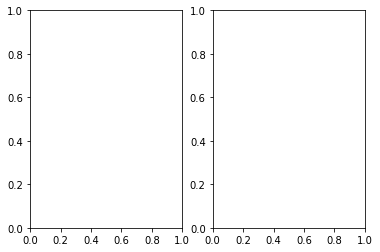

In [14]:
fig,ax=plt.subplots(ncols=2)

if isinstance(ax,np.ndarray):
    print('True')

In [15]:
def plot_importance(tree, top_n=20,figsize=(10,10)):
    df_importance = pd.Series(tree.feature_importances_,index=X_train.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize)
    return df_importance

## Write a fucntion to evalute the model
import sklearn.metrics as metrics

def evaluate_model(y_true, y_pred,X_true,clf,cm_kws=dict(cmap="Greens",
                                  normalize='true'),figsize=(10,4),plot_roc_auc=True):
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_true,y_pred))

    if plot_roc_auc:
        num_cols=2
    else:
        num_cols=1
        
    fig, ax = plt.subplots(figsize=figsize,ncols=num_cols)
    
    if not isinstance(ax,np.ndarray):
        ax=[ax]
    metrics.plot_confusion_matrix(clf,X_true,y_true,ax=ax[0],**cm_kws)
    ax[0].set(title='Confusion Matrix')
    
    if plot_roc_auc:
        try:
            y_score = clf.predict_proba(X_true)[:,1]

            fpr,tpr,thresh = metrics.roc_curve(y_true,y_score)
            # print(f"ROC-area-under-the-curve= {}")
            roc_auc = round(metrics.auc(fpr,tpr),3)
            ax[1].plot(fpr,tpr,color='darkorange',label=f'ROC Curve (AUC={roc_auc})')
            ax[1].plot([0,1],[0,1],ls=':')
            ax[1].legend()
            ax[1].grid()
            ax[1].set(ylabel='True Positive Rate',xlabel='False Positive Rate',
                  title='Receiver operating characteristic (ROC) Curve')
            plt.tight_layout()
            plt.show()
        except:
            pass
    try: 
        df_important = plot_importance(clf)
    except:
        df_important = None
    
#     return df_important
## visualize the decision tree
def visualize_tree(tree,feature_names=None,class_names=['0','1'],
                   kws={},save_filename=None,format_='png',save_and_show=False):
    """Visualizes a sklearn tree using sklearn.tree.export_graphviz"""
    from sklearn.tree import export_graphviz
    from IPython.display import SVG
    import graphviz #import Source
    from IPython.display import display
    
    if feature_names is None:
        feature_names=X_train.columns

    tree_viz_kws =  dict(out_file=None,rounded=True, rotate=False, filled = True)
    tree_viz_kws.update(kws)

    # tree.export_graphviz(dt) #if you wish to save the output to a dot file instead
    tree_data=export_graphviz(tree,feature_names=feature_names, 
                                   class_names=class_names,**tree_viz_kws)
    graph = graphviz.Source(tree_data,format=format_)#'png')
    
    if save_filename is not None:
        graph.render(save_filename)
        if save_and_show:
            display(graph)
        else:
            print(f'[i] Tree saved as {save_filename}.{format_}')
    else:
        display(graph)

#     display(SVG(graph.pipe(format=format_)))#'svg')))

# Obtain

In [16]:
df = fs.datasets.load_iowa_prisoners(vers='clean',read_csv_kwds={'index_col':0})
df.head()

,yr_released,report_year,race_ethnicity,age_released,crime_class,crime_type,crime_subtype,release_type,super_dist,recidivist,target_pop,sex
0,2010,2013,Black - Non-Hispanic,25-34,C Felony,Violent,Robbery,Parole,7JD,Yes,Yes,Male
1,2010,2013,White - Non-Hispanic,25-34,D Felony,Property,Theft,Discharged – End of Sentence,NaN,Yes,No,Male
2,2010,2013,White - Non-Hispanic,35-44,B Felony,Drug,Trafficking,Parole,5JD,Yes,Yes,Male
3,2010,2013,White - Non-Hispanic,25-34,B Felony,Other,Other Criminal,Parole,6JD,No,Yes,Male
4,2010,2013,Black - Non-Hispanic,35-44,D Felony,Violent,Assault,Discharged – End of Sentence,NaN,Yes,No,Male


In [17]:
## Drop unwanted cols
df= df.drop(columns=['yr_released','report_year'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26020 entries, 0 to 26019
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   race_ethnicity  25990 non-null  object
 1   age_released    26017 non-null  object
 2   crime_class     26020 non-null  object
 3   crime_type      26020 non-null  object
 4   crime_subtype   26020 non-null  object
 5   release_type    24258 non-null  object
 6   super_dist      16439 non-null  object
 7   recidivist      26020 non-null  object
 8   target_pop      26020 non-null  object
 9   sex             26017 non-null  object
dtypes: object(10)
memory usage: 2.2+ MB


race_ethnicity      30
age_released         3
crime_class          0
crime_type           0
crime_subtype        0
release_type      1762
super_dist        9581
recidivist           0
target_pop           0
sex                  3
dtype: int64

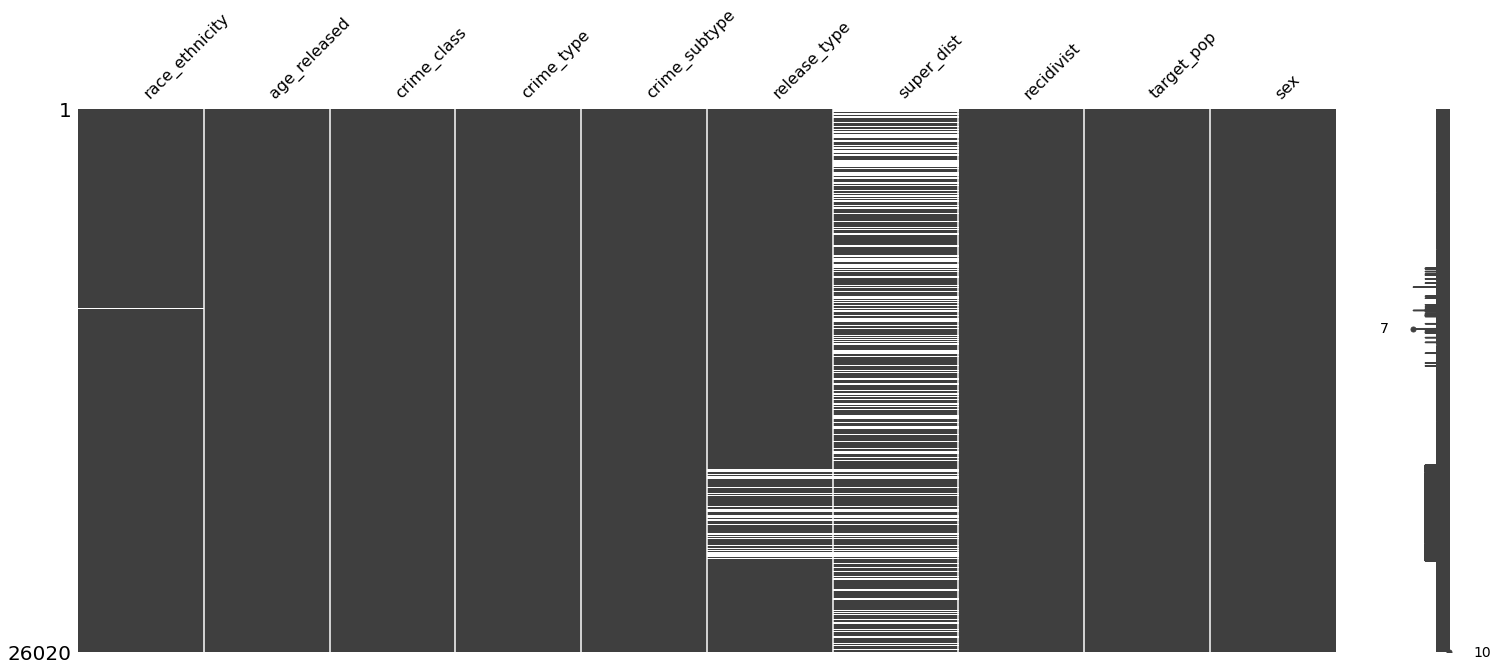

In [18]:
## Check null values
import missingno
missingno.matrix(df)
df.isna().sum()

In [19]:
df['race_ethnicity'].value_counts(dropna=False)

White - Non-Hispanic                               17584
Black - Non-Hispanic                                6109
White - Hispanic                                    1522
American Indian or Alaska Native - Non-Hispanic      502
Asian or Pacific Islander - Non-Hispanic             192
Black - Hispanic                                      37
NaN                                                   30
American Indian or Alaska Native - Hispanic           20
White -                                               12
N/A -                                                  5
Asian or Pacific Islander - Hispanic                   5
Black -                                                2
Name: race_ethnicity, dtype: int64

In [20]:
# Defining Dictionary Map for race_ethnicity categories
race_ethnicity_map = {'White - Non-Hispanic':'White',
                        'Black - Non-Hispanic': 'Black',
                        'White - Hispanic' : 'Hispanic',
                        'American Indian or Alaska Native - Non-Hispanic' : 'American Native',
                        'Asian or Pacific Islander - Non-Hispanic' : 'Asian or Pacific Islander',
                        'Black - Hispanic' : 'Black',
                        'American Indian or Alaska Native - Hispanic':'American Native',
                        'White -' : 'White',
                        'Asian or Pacific Islander - Hispanic' : 'Asian or Pacific Islander',
                        'N/A -' : np.nan,
                        'Black -':'Black'}

df['race_ethnicity'] = df['race_ethnicity'].map(race_ethnicity_map)
df['race_ethnicity'].value_counts(dropna=False)

White                        17596
Black                         6148
Hispanic                      1522
American Native                522
Asian or Pacific Islander      197
NaN                             35
Name: race_ethnicity, dtype: int64

In [21]:
df['crime_class'].value_counts()

D Felony                                    10487
C Felony                                     6803
Aggravated Misdemeanor                       4930
B Felony                                     1765
Felony - Enhancement to Original Penalty     1533
Felony - Enhanced                             220
Serious Misdemeanor                           155
Special Sentence 2005                          98
Felony - Mandatory Minimum                     11
Other Felony                                    6
A Felony                                        4
Simple Misdemeanor                              3
Other Felony (Old Code)                         2
Sexual Predator Community Supervision           2
Other Misdemeanor                               1
Name: crime_class, dtype: int64

In [22]:
# Remapping
crime_class_map = {'Other Felony (Old Code)': np.nan ,#or other felony
                  'Other Misdemeanor':np.nan,
                   'Felony - Mandatory Minimum':np.nan, # if minimum then lowest sentence ==  D Felony
                   'Special Sentence 2005': 'Sex Offender',
                   'Other Felony' : np.nan ,
                   'Sexual Predator Community Supervision' : 'Sex Offender',
                   'D Felony': 'D Felony',
                   'C Felony' :'C Felony',
                   'B Felony' : 'B Felony',
                   'A Felony' : 'A Felony',
                   'Aggravated Misdemeanor':'Aggravated Misdemeanor',
                   'Felony - Enhancement to Original Penalty':'Felony - Enhanced',
                   'Felony - Enhanced':'Felony - Enhanced' ,
                   'Serious Misdemeanor':'Serious Misdemeanor',
                   'Simple Misdemeanor':'Simple Misdemeanor'}

df['crime_class'] = df['crime_class'].map(crime_class_map)
df['crime_class'].value_counts(dropna=False)

D Felony                  10487
C Felony                   6803
Aggravated Misdemeanor     4930
B Felony                   1765
Felony - Enhanced          1753
Serious Misdemeanor         155
Sex Offender                100
NaN                          20
A Felony                      4
Simple Misdemeanor            3
Name: crime_class, dtype: int64

In [23]:
df['age_released'].value_counts(dropna=False)

25-34           9554
35-44           6223
Under 25        4590
45-54           4347
55 and Older    1303
NaN                3
Name: age_released, dtype: int64

In [24]:
# Encoding age groups as ordinal
age_ranges = ('Under 25','25-34', '35-44','45-54','55 and Older')
age_codes = (0,1,2,3,4) 
# Zipping into Dictionary to Map onto Column
age_map = dict(zip(age_ranges,age_codes))
age_map

{'Under 25': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55 and Older': 4}

In [25]:
df['age_enc'] = df['age_released'].map(age_map)
df['age_enc'].value_counts()

1.0    9554
2.0    6223
0.0    4590
3.0    4347
4.0    1303
Name: age_enc, dtype: int64

In [26]:
# Mapping age_map onto 'age_released'
# Encoding age groups as ordinal
age_ranges = ('Under 25','25-34', '35-44','45-54','55 and Older')
age_numbers = (20,30,40,50,70) 
age_num_map = dict(zip(age_ranges,age_numbers))
age_num_map

{'Under 25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55 and Older': 70}

In [27]:
df['age_number'] = df['age_released'].map(age_num_map)
df['age_number'].value_counts()

30.0    9554
40.0    6223
20.0    4590
50.0    4347
70.0    1303
Name: age_number, dtype: int64

In [28]:
## Drop Nulls 
print(df.isna().sum().divide(len(df))*100)
drop_cols  = [col for col in df.drop(columns=['super_dist','release_type']).columns]
drop_cols

race_ethnicity     0.134512
age_released       0.011530
crime_class        0.076864
crime_type         0.000000
crime_subtype      0.000000
release_type       6.771714
super_dist        36.821676
recidivist         0.000000
target_pop         0.000000
sex                0.011530
age_enc            0.011530
age_number         0.011530
dtype: float64


['race_ethnicity',
 'age_released',
 'crime_class',
 'crime_type',
 'crime_subtype',
 'recidivist',
 'target_pop',
 'sex',
 'age_enc',
 'age_number']

In [29]:
df.dropna(subset=drop_cols, inplace=True)
df.isna().sum()

race_ethnicity       0
age_released         0
crime_class          0
crime_type           0
crime_subtype        0
release_type      1759
super_dist        9539
recidivist           0
target_pop           0
sex                  0
age_enc              0
age_number           0
dtype: int64

In [30]:
df[['super_dist','release_type']] = df[['super_dist','release_type']].fillna('Missing')
df.isna().sum()

race_ethnicity    0
age_released      0
crime_class       0
crime_type        0
crime_subtype     0
release_type      0
super_dist        0
recidivist        0
target_pop        0
sex               0
age_enc           0
age_number        0
dtype: int64

In [31]:
drop_cols = ['age_released']
df = df.drop(columns=drop_cols)

In [32]:
# one_hot_cols = ['race_ethnicity','crime_class
df = pd.get_dummies(df)#,dummy_na=True)
df.head()

,age_enc,age_number,race_ethnicity_American Native,race_ethnicity_Asian or Pacific Islander,race_ethnicity_Black,race_ethnicity_Hispanic,race_ethnicity_White,crime_class_A Felony,crime_class_Aggravated Misdemeanor,crime_class_B Felony,...,super_dist_8JD,super_dist_ISC,super_dist_Interstate Compact,super_dist_Missing,recidivist_No,recidivist_Yes,target_pop_No,target_pop_Yes,sex_Female,sex_Male
0,1.0,30.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,1.0,30.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,1
2,2.0,40.0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,1
3,1.0,30.0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,1
4,2.0,40.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,1


In [33]:
df.drop('recidivist_No',axis=1,inplace=True)

In [34]:
y = df.pop('recidivist_Yes')
df

,age_enc,age_number,race_ethnicity_American Native,race_ethnicity_Asian or Pacific Islander,race_ethnicity_Black,race_ethnicity_Hispanic,race_ethnicity_White,crime_class_A Felony,crime_class_Aggravated Misdemeanor,crime_class_B Felony,...,super_dist_6JD,super_dist_7JD,super_dist_8JD,super_dist_ISC,super_dist_Interstate Compact,super_dist_Missing,target_pop_No,target_pop_Yes,sex_Female,sex_Male
0,1.0,30.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,1.0,30.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,1
2,2.0,40.0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,1.0,30.0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,1
4,2.0,40.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26015,0.0,20.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
26016,2.0,40.0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
26017,1.0,30.0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
26018,1.0,30.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [35]:
from sklearn.model_selection import train_test_split

## Train test split
X_train, X_test, y_train,y_test  = train_test_split(df,y,test_size=.3,random_state=42)
y_train.value_counts(normalize=False)

0    12074
1     6101
Name: recidivist_Yes, dtype: int64

In [36]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority',random_state=42)
rus

RandomUnderSampler(random_state=42, sampling_strategy='majority')

In [37]:
X_train, y_train = rus.fit_resample(X_train, y_train)
pd.Series(y_train).value_counts()

1    6101
0    6101
Name: recidivist_Yes, dtype: int64

In [38]:
# smote = SMOTE()
# X_train, y_train = smote.fit_sample(X_train, y_train)
# pd.Series(y_train).value_counts()

In [39]:
# px.scatter_matrix(df, color='recidivist')

## RandomForests Revisited

[i] Timer started at 	09/30/20 - 02:44:55 PM
Training score:  0.63
Test score:  0.61


------------------------------------------------------------
	TIMER LOG
------------------------------------------------------------
[i] Timer started at 	09/30/20 - 02:44:55 PM
[i] Timer ended at 	09/30/20 - 02:44:56 PM
			- Total time = 0:00:01.321834
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.56      0.66      5216
           1       0.44      0.69      0.54      2574

    accuracy                           0.61      7790
   macro avg       0.61      0.63      0.60      7790
weighted avg       0.67      0.61      0.62      7790



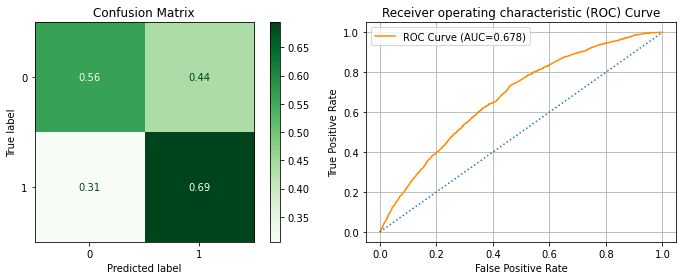

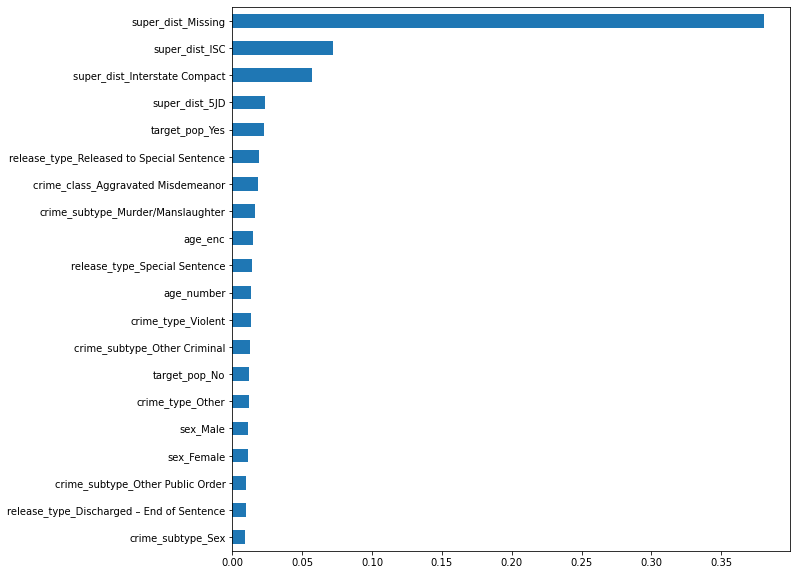

In [40]:
from xgboost import XGBRFClassifier,XGBClassifier
## Fit and Evaluate
timer = Timer(verbose=2)#.start()

xgb_rf = XGBRFClassifier()
xgb_rf.fit(X_train, y_train)
print('Training score: ' ,round(xgb_rf.score(X_train,y_train),2))
print('Test score: ',round(xgb_rf.score(X_test,y_test),2))

y_hat_test = xgb_rf.predict(X_test)
timer.stop()

evaluate_model(y_test,y_hat_test,X_test,xgb_rf)


In [41]:
importance = pd.Series(xgb_rf.feature_importances_,
                       index=X_train.columns).sort_values(ascending=False)
display(importance.head(20))
top_cols = list(importance.head(20).index)
top_cols

super_dist_Missing                           0.380491
super_dist_ISC                               0.072008
super_dist_Interstate Compact                0.057280
super_dist_5JD                               0.023540
target_pop_Yes                               0.022258
release_type_Released to Special Sentence    0.019072
crime_class_Aggravated Misdemeanor           0.018524
crime_subtype_Murder/Manslaughter            0.016407
age_enc                                      0.014939
release_type_Special Sentence                0.014054
age_number                                   0.013393
crime_type_Violent                           0.013371
crime_subtype_Other Criminal                 0.012851
target_pop_No                                0.011924
crime_type_Other                             0.011892
sex_Male                                     0.011342
sex_Female                                   0.011286
crime_subtype_Other Public Order             0.009979
release_type_Discharged – En

['super_dist_Missing',
 'super_dist_ISC',
 'super_dist_Interstate Compact',
 'super_dist_5JD',
 'target_pop_Yes',
 'release_type_Released to Special Sentence',
 'crime_class_Aggravated Misdemeanor',
 'crime_subtype_Murder/Manslaughter',
 'age_enc',
 'release_type_Special Sentence',
 'age_number',
 'crime_type_Violent',
 'crime_subtype_Other Criminal',
 'target_pop_No',
 'crime_type_Other',
 'sex_Male',
 'sex_Female',
 'crime_subtype_Other Public Order',
 'release_type_Discharged – End of Sentence',
 'crime_subtype_Sex']

# Using SHAP and Shapely Values for Model Interpretation




- White Paper on Shapely Values:
    - https://arxiv.org/abs/1705.07874
    
- Blog Posts:
    - https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

    - https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a


- Videos/Talks:
    - ["Open the Black Box: an intro to Model Interpretability with LIME and SHAP](https://youtu.be/C80SQe16Rao)
    

## Using SHAP

- Uses game theory to explain feature importance and how a feature steered a model's prediction(s) by removing each feature and seeing the effect on the error.

- SHAP has:
    - `TreeExplainer`:
        - compatible with sckit learn, xgboost, Catboost
    - `KernelExplainer`:
        - compatible with "any" model
        


- See [this blog post](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) for intro to topic and how to use with trees

- For non-tree/random forest models [see this follow up post]( https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

        

### To Get Expanations for Trees:



- Import and initialize javascript:

```python
import shap 
shap.initjs()
```
1. Create a shap explainer using your fit model.

```python
explainer = shap.TreeExplainer(xgb_clf)
```

2. Get shapely values from explainer for your training data

```python
shap_values = explainer.shap_values(X_train,y_train)
```            

3. Select which type of the available plots you'd like to visualize

    
- **Types of Plots:**
    - `summary_plot()`
    - `dependence_plot()`
    - `force_plot()` for a given observation
    - `force_plot()` for all data

### Summary Plot

```python

## For normal bar graph of importance:
shap.summary_plot(shap_values,X_train,plot_type='bar')

## For detail Shapely value visuals:
shap.summary_plot(shap_values, X_train)
```

**`shap.summary_plot`**
> - Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.


**`shap.dependence_plot`**


```python
## To Auto-Select Feature Most correlated with a specific feature, just pass the desired feature's column name.

shap.dependence_plot('super_dist', shap_values, X_train)

## There is a way to specifically call out multiple features but I wasn't able to summarize it quickly for this nb
```

`shap.force_plot`

To show an individual data point's prediction and the factors pushing it towards one class or another

```python
## Just using np to randomly select a row

row = np.random.choice(range(len(X_train))
                       
shap.force_plot(explainer.expected_value, shap_values[row,:], X_train.iloc[row,:])
```

In [45]:
# !pip install shap


In [47]:
import shap
shap.initjs()

In [48]:
# shap_values = shap.TreeExplainer(xgb_rf).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

In [49]:
explainer = shap.TreeExplainer(xgb_rf)
shap_values = explainer.shap_values(X_train)

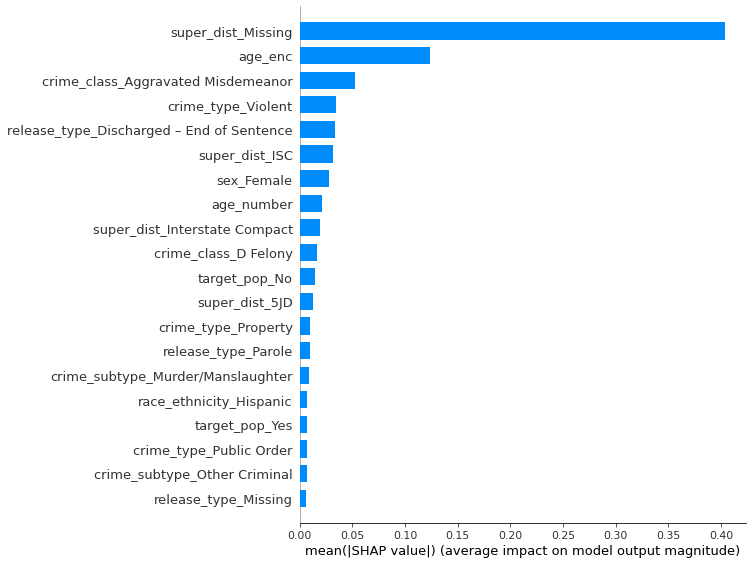

In [50]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

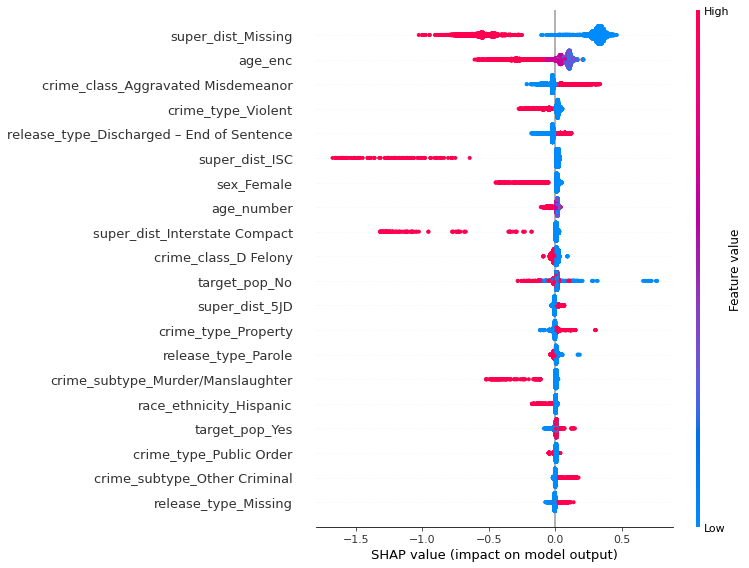

In [51]:
shap.summary_plot(shap_values, X_train)#, plot_type="bar")

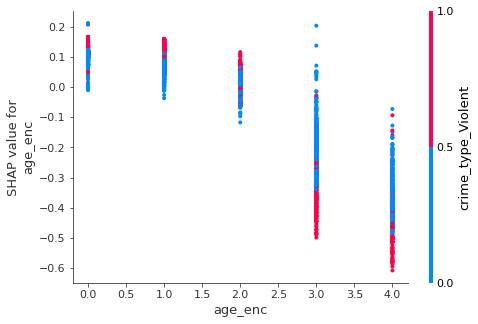

In [52]:
shap.dependence_plot('age_enc', shap_values, X_train)#"rank(1)"

In [53]:
row = np.random.choice(range(len(X_train)))
display(X_train.iloc[row])                       
shap.force_plot(explainer.expected_value, shap_values[row,:], X_train.iloc[row])

age_enc                                      2.0
age_number                                  40.0
race_ethnicity_American Native               0.0
race_ethnicity_Asian or Pacific Islander     0.0
race_ethnicity_Black                         0.0
                                            ... 
super_dist_Missing                           0.0
target_pop_No                                1.0
target_pop_Yes                               0.0
sex_Female                                   0.0
sex_Male                                     1.0
Name: 10751, Length: 74, dtype: float64

## Support Vector Machines

In [ ]:
import os,glob,sys
folder ='py_files/'
sys.path.append(os.path.abspath(folder))
import mod_5_functions as m5

In [ ]:
# # X_train[top_cols]
# X_train.shape
# X_train = X_train[top_cols]
# X_test = X_test[top_cols]

In [ ]:
# np.logspace(0.01, 10,0.1)
np.logspace(-1,1,3)

In [ ]:
# from sklearn.pre

In [ ]:
from sklearn.svm import SVC,LinearSVC,NuSVC
clf = SVC()
clf.fit(X_train,y_train)
y_hat_test = clf.predict(X_test)
evaluate_model(y_test,y_hat_test,X_test,clf)

# Pipelines

Scikit-learn has a class called [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that is very logical and versatile. We can break up the steps within a full process. But it'll help if we define what the different parts are.

## Estimator

This is any object in the pipeline that can can take in data and *estimate* (or **learn**) some parameters. 

This means regression and classification models are estimators but so are objects that transform the original dataset ([Transformers](pipeline_intro.ipynb#Transformer)) such as a standard scaling.

### Usage (Methods)

#### `fit`

All estimators estimate/learn by calling the `fit()` method by passing in the dataset. Other parameters can be passed in to "help" the estimator to learn. These are called **hyperparameters**, parameters used to tweak the learning process.

## Transformer

Some estimators can change the original data to something new, a **transformation**. You can think of examples of these **transformers** when you do scaling, data cleaning, or expanding/reducing on a dataset.

### Usage (Methods)

#### `transform`

Transformers will call the `transform()` method to apply the transformation to a dataset.

####  `fit_transform`

Remember that all estimators have a `fit()` method, so a transformer can use the `fit()` method to learn something about the given dataset. After learning with `fit()`, a transformation on the dataset can be made with the `transform()` method. 

An example of this would be a function that performs normalization on the dataset; the `fit()` method would learn the minimum and maximum of the dataset and the `transform()` method will scale the dataset.

When you call `fit` and `transform` with the same dataset, you can simply call the `fit_transform()` method. This essentially has the same results as calling `fit()` and then `transform()` on the dataset but possibly with some optimization and efficiencies baked in.

## Predictor

We've been using **predictors** whenever we've been making predictions with a classifier or regressor. We would use the `fit()` method to train our predictor object and then feed in new data to make predictions (based on what it learned in the fitting stage).

### Usage (Methods)

#### `predict`

As you probably can guess, the `predict()` method predicts results from a dataset given to it after being trained with a `fit()` method

#### `score`

Predictors also have a `score()` method that can be used to evaluate how well the predictor performed on a dataset (such as the test set).

# Example of Using a Pipeline (Other dataset)

We can imagine doing the full steps planned out for a dataset. We _technically_ don't need to use the Pipeline class but it makes it much more manageable

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Getting some data
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=27)

## Without the Pipeline class

In [ ]:
# Define transformers (will adjust/massage the data)
imputer = SimpleImputer(strategy="median") # replaces missing values
std_scaler = StandardScaler() # scales the data
pca = PCA()

In [ ]:
# Define the classifier (predictor) to train
rf_clf = RandomForestClassifier()

# Have the classifer (and full pipeline) learn/train/fit from the data
X_train_filled = imputer.fit_transform(X_train)
X_train_scaled = std_scaler.fit_transform(X_train_filled)
X_train_reduce = pca.fit_transform(X_train_scaled)
rf_clf.fit(X_train_reduce, y_train)

# Predict using the trained classifier (still need to do the transformations)
X_test_filled = imputer.transform(X_test)
X_test_scaled = std_scaler.transform(X_test_filled)
X_test_reduce = pca.fit_transform(X_test_scaled)
y_pred = rf_clf.predict(X_test_reduce)


> Note that if we were to add more steps in this process, we'd have to change both the *training* and *testing* processes.

## With the Pipeline class

In [ ]:
from sklearn.pipeline import Pipeline
pipe =Pipeline([('imputer',SimpleImputer(strategy='median') ),
                ('scaler',StandardScaler()),
               ('clf',RandomForestClassifier())] ,verbose=True)
pipe

In [ ]:
# Train the pipeline (tranformations & predictor)
pipe.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipe.predict(X_test)

In [ ]:
pipe.named_steps['clf']

In [ ]:
evaluate_model(y_test,predicted,X_test,pipe.named_steps['clf'])

In [ ]:

pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), 
        ('std_scaler', StandardScaler()),
        ('pca', PCA()),
        ('rf_clf', RandomForestClassifier()),
])


# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

In [ ]:
pipe.named_steps['clf'].max_depth=5

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'imputer__strategy':['mean','median','most_frequent'],
              'clf__max_depth':[3,4]
             }
search = GridSearchCV(pipe,param_grid)

timer =Timer(verbose=2)
search.fit(X_train,y_train)

In [ ]:
search.best_params_

In [ ]:
bestpipe = search.best_estimator_
bestpipe

> If we need to change our process, we change it _just once_ in the Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
pipe = Pipeline([('sca',MinMaxScaler()),
#                  ('pca',PCA(n_components=20)),
                ('clf',SVC(probability=True))])
pipe

In [ ]:
timer=Timer(verbose=2)
pipe.fit(X_train,y_train)
timer.stop()

In [ ]:
y_hat_test = pipe.predict(X_test)
evaluate_model(y_test,y_hat_test,X_test,pipe.named_steps['clf'],plot_roc_auc=False)


### GridSearch a Pipeline

In [ ]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
#     'sca__feature_range': [(0,1)],#,(-1,1)],
    'clf__C':[0.1,0.5,1,10],#list( np.logspace(-2,1,2)),
}
search = GridSearchCV(pipe,param_grid)
search

In [ ]:
timer=Timer(verbose=2)
search.fit(X_train, y_train)
timer.stop()
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


In [ ]:
bestpipe = search.best_estimator_
bestpipe

In [ ]:
y_hat_test = bestpipe.predict(X_test)
evaluate_model(y_test,y_hat_test,X_test,bestpipe.named_steps['clf'])

In [ ]:
# timer = Timer()
# timer.start()
# svc.fit(X_train[top_cols],y_train)

# print(svc.score(X_test[top_cols],y_test))
# timer.stop()

In [ ]:
# y_hat_test = svc.predict(X_test[top_cols])
# evaluate_model(y_test,y_hat_test,X_test[top_cols], svc)#,conf_matrix_kws={'normalize':True})

# Let's peak inside this black box
[SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

[Explain Any Model with SHAP KernelExplaibner](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

In [ ]:
# !pip install -U shap
import shap
shap.initjs()

In [ ]:
X_shap = shap.sample(X_test,nsamples=5)
explainer = shap.KernelExplainer(svc.predict,X_shap)#.shap_values()
shap_values = explainer.shap_values(X_shap)
# # # rf_shap_values = shap.KernelExplainer(rf.predict,X_test)

In [ ]:
shap.summary_plot(shap_values,X_shap)

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_shap)

shap.force_plot(explainer.expected_value, shap_values, X_test)

# Using a Pipeline

Check out Aurélien Geron's notebook of an [end-to-end ml project](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on his GitHub repo based around his book [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed)_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)